### Final Project For Kevin Rocca ###

### Introduction ###
Lorem ipsum

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid, elu
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

In [2]:
def zscore_normalize_features(X):
  """
  computes  X, zcore normalized by column
  
  Args:
    X (ndarray (m,n))     : input data, m examples, n features
    
  Returns:
    X_norm (ndarray (m,n)): input normalized by column
    mu (ndarray (n,))     : mean of each feature
    sigma (ndarray (n,))  : standard deviation of each feature
  """
  # find the mean of each column/feature
  mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
  # find the standard deviation of each column/feature
  sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
  # element-wise, subtract mu for that column from each example, divide by std for that column
  X_norm = (X - mu) / sigma      

  return (X_norm)

In [7]:
def load_and_process_data(filename):
  '''
  Load the data from the file given im {filename}.
  Ignore the fist value which just contains a timestamp
  and convert the plant health into a number 0-2. The function also
  balances this particular dataset, removing any skews.
  Args:
  filename : string with the name of the file to load
  Returns:
  X_train (np array (N, m)) : Training data, N * .6 examples by m features
  y_train (np array (N, 1)) : Testing data, N * .6 examples by 1 feature
  
  X_test (np array (N, m)) : Training data, N * .2 examples by m features
  y_test (np array (N, 1)) : Testing data, N * .2 examples by 1 feature
  
  X_cv (np array (N, m)) : Training data, N * .2 examples by m features
  y_cv (np array (N, 1)) : Testing data, N * .2 examples by 1 feature
  '''
  data = np.genfromtxt(filename, delimiter=',', dtype=str)
  X = data[1:, 1:13].astype(float) # skip first row, first and last columns
  y = data[1:, 13:] # skip first row and only grab the last column

  # Normalize the data
  X_Norm = zscore_normalize_features(X)

  # Convert the health_status string to an integer
  label_map = {
    "Healthy": 0,
    "Moderate Stress": 1,
    "High Stress": 2
  }
  y_mapped = np.array([label_map[label] for label in y.flatten()])
  
  # Check whether there is a skew in the dataset and how bad it is.
  print(f"\nAmount of healthy plants in the original dataset {np.count_nonzero(y_mapped == 0)}")
  print(f"Amount of moderately stressed plants in the original dataset {np.count_nonzero(y_mapped == 1)}")
  print(f"Amount of highly stressed plants in the original dataset {np.count_nonzero(y_mapped == 2)}")

  # Address class imbalance. Get indices for each class
  idx_healthy = np.where(y_mapped == 0)[0]
  idx_high_stress = np.where(y_mapped == 2)[0]

  # Duplicate 100 random indices from the pool of healthy plants
  np.random.seed(1)
  duplicated_healthy = np.random.choice(idx_healthy, 100, replace=True)
  
  # Add the examples. Use vstack for 2D numpy arrays 
  for idx in duplicated_healthy:
    X_Norm = np.vstack([X_Norm, X_Norm[idx]])
    y_mapped =np.append(y_mapped, y_mapped[idx])

  # Find 100 random indices from high stress plants
  reduced_high_stress = np.random.choice(idx_high_stress, 100, replace=False)
  # Sort the indices so when we remove them, we can remove from the furthest right index to the
  # furthest left one, thus preserving order.
  reduced_high_stress = sorted(reduced_high_stress, reverse=True)

  for idx in reduced_high_stress:
    X_Norm = np.delete(X_Norm, idx, axis=0)
    y_mapped = np.delete(y_mapped, idx)

  N = len(X_Norm)
  train_end = int(0.6 * N)
  test_end = train_end + int(0.2 * N)
  
  X_train = X_Norm[:train_end]
  y_train = y_mapped[:train_end]
  X_test = X_Norm[train_end:test_end]
  y_test = y_mapped[train_end:test_end]
  X_cv = X_Norm[test_end:]
  y_cv = y_mapped[test_end:]

  return X_train, y_train, X_test, y_test, X_cv, y_cv


### Show the loaded training, testing, and cross validation sets. Note that all 1200 examples are used. ###
This also shows how the load_and_process_data function de-skews the dataset.

In [8]:
# Load the sets
X_train, y_train, X_test, y_test, X_cv, y_cv = load_and_process_data("./data/plant_health_data.csv")
print()

# Show the data in the sets
print(f"X_train data has the form: {X_train[0]}")
print(f"y_train data has the form: {y_train[0]}")
print()

# Show the amount of data in each set. Note that 720 + 240 + 240 = 1200 which is the total amount of examples we have
print("The shape of each set. Examples by features")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_cv.shape)
print(y_cv.shape)

# Now let us check whether the dataset is de-skewed
print(f"\nAmount of healthy plants {np.count_nonzero(y_train == 0) + np.count_nonzero(y_cv == 0) + np.count_nonzero(y_test == 0)}")
print(f"Amount of moderately stressed plants {np.count_nonzero(y_train == 1) + np.count_nonzero(y_cv == 1) + np.count_nonzero(y_test == 1)}")
print(f"Amount of highly stressed plants {np.count_nonzero(y_train == 2) + np.count_nonzero(y_cv == 2) + np.count_nonzero(y_test == 2)}")



Amount of healthy plants in the original dataset 299
Amount of moderately stressed plants in the original dataset 401
Amount of highly stressed plants in the original dataset 500

X_train data has the form: [-1.5666989  -1.1841392  -0.6663611  -0.43567633  1.03584462 -0.07229987
  1.05174414  0.0526353  -0.4248877  -1.04321622 -0.7709725  -1.43137704]
y_train data has the form: 2

The shape of each set. Examples by features
(720, 12)
(720,)
(240, 12)
(240,)
(240, 12)
(240,)

Amount of healthy plants 399
Amount of moderately stressed plants 401
Amount of highly stressed plants 400


### Find the best architecture from a group ### 
This function only uses dense layers, and though I could test convolutional layers, it runs fast enough that I see no clear benefit.

In [5]:
def test_model_architectures(X_train, y_train, X_cv, y_cv, epochs=25):
  """
  Test various model architectures to find the best one.
  Args:
  The training set, cross validation set, and how many epochs to run. Defaults to 25 epochs.
  Returns:
  models: A list of all computed models based on differing layer architectures and activation parameters.
          Note that all models use a softmax output as it is the only one we discussed for multiclassification
  accuracies: A list of the training and testing accuracies for each model 
  """
  architectures = [
    [60, 20], # 2 layers small
    [120, 40],  # 2 layers
    [150, 75, 30],  # 3 layers
    [200, 100, 50, 25],  # 4 layers
    [300, 150, 75, 50, 25]  # 5 layers
  ]
  models = []
  accuracies = []
  i = 0

  # Run on Dense Layers with ReLU
  for arch in architectures:
    model = Sequential()
    for units in arch:
      model.add(Dense(units=units, activation="relu"))
    model.add(Dense(units=3, activation="softmax"))  # Final output layer for 3 classes

    model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      metrics=['accuracy']
    )
    
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    _, cv_accuracy = model.evaluate(X_cv, y_cv, verbose=0)
    _, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    
    accuracies.append([train_accuracy, cv_accuracy])
    models.append(model)

    print(f"Finished with relu model {i}. Loop {i + 1} / {len(architectures)}")
    i += 1


  i = 0
  # Run on Dense Layers with sigmoid
  for arch in architectures:
    model = Sequential()
    for units in arch:
      model.add(Dense(units=units, activation="sigmoid"))
    model.add(Dense(units=3, activation="softmax"))  # Final output layer for 3 classes

    model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      metrics=['accuracy']
    )
    
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    _, cv_accuracy = model.evaluate(X_cv, y_cv, verbose=0)
    _, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    
    accuracies.append([train_accuracy, cv_accuracy])
    models.append(model)

    print(f"Finished with sigmoid model {i}. Loop {i + 1} / {len(architectures)}")
    i += 1

  i = 0
  # Run on Dense Layers with eLU (Exponential linear units)
  for arch in architectures:
    model = Sequential()
    for units in arch:
      model.add(Dense(units=units, activation="elu"))
    model.add(Dense(units=3, activation="softmax"))  # Final output layer for 3 classes

    model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      metrics=['accuracy']
    )
    
    model.fit(X_train, y_train, epochs=30, verbose=0)
    _, cv_accuracy = model.evaluate(X_cv, y_cv, verbose=0)
    _, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    
    accuracies.append([train_accuracy, cv_accuracy])
    models.append(model)

    print(f"Finished with elu model {i}. Loop {i + 1} / {len(architectures)}")
    i += 1

  return models, accuracies

In the code block below, the ReLU models generalized the worst while the Elu models did slightly better. However, the clear champions by far were the Sigmoid models. They all generalized very well and had low differences between the cross validation cost and the training cost. As for the specific layer and neuron count, it seemed that after running the above code a few times, model 8 had generalized the best and had the lowest difference between the training and testing accuracy.

In [6]:
models, accuracies = test_model_architectures(X_train, y_train, X_cv, y_cv, 60)

# Determine the accuracy of the model on the training and cross validation data. 
# Choose the one that has the lowest difference between the training and cross validation data.
best_difference = 1.0
for i in range(len(accuracies)):
  if i == 0:
    print(f"\nReLU Models")
  if i == 5:
    print(f"\nSigmoid Models")
  if i == 10:
    print(f"\nElu models")
  print(f"Model {i} has a training accuracy of {accuracies[i][0]} and a cv accuracy of {accuracies[i][1]} ")
  if accuracies[i][0] - accuracies[i][1] < best_difference:
    model_number = i
    best_difference = abs(accuracies[i][0] - accuracies[i][1])

print(f"\nBest model overall is model {model_number} with a difference of {best_difference}.")

Finished with relu model 0. Loop 1 / 5
Finished with relu model 1. Loop 2 / 5
Finished with relu model 2. Loop 3 / 5
Finished with relu model 3. Loop 4 / 5
Finished with relu model 4. Loop 5 / 5
Finished with sigmoid model 0. Loop 1 / 5
Finished with sigmoid model 1. Loop 2 / 5
Finished with sigmoid model 2. Loop 3 / 5
Finished with sigmoid model 3. Loop 4 / 5
Finished with sigmoid model 4. Loop 5 / 5
Finished with elu model 0. Loop 1 / 5
Finished with elu model 1. Loop 2 / 5
Finished with elu model 2. Loop 3 / 5
Finished with elu model 3. Loop 4 / 5
Finished with elu model 4. Loop 5 / 5

ReLU Models
Model 0 has a training accuracy of 1.0 and a cv accuracy of 0.925000011920929 
Model 1 has a training accuracy of 1.0 and a cv accuracy of 0.8666666746139526 
Model 2 has a training accuracy of 1.0 and a cv accuracy of 0.8833333253860474 
Model 3 has a training accuracy of 1.0 and a cv accuracy of 0.9041666388511658 
Model 4 has a training accuracy of 1.0 and a cv accuracy of 0.88333332538

### The function below finds the optimal lambda value ###
This function runs a set of differing lambda values on the function I determined to be best in the above code.

In [7]:
def test_optimal_lambda(epochs=100):
  """
  Test various lambda parameters to find the best one.
  Args:
  How many epochs to run. Defaults to 100 epochs.
  Returns:
  lambda_models: A list of all computed models based on differing lambda values.
  lambda_accuracies: A list of the training and testing accuracies for each model
  lambdas: the lambda values used to train each model
  """
  # tf.random.set_seed(0)
  lambdas = [0.0, 0.000001, 0.00001, 0.00005, 0.001, 0.01, 0.1]
  lambda_models= []
  lambda_accuracies = []
  i = 0
  for lambda_ in lambdas:
    lambda_model = Sequential()
    lambda_model.add(Dense(units=200, activation="sigmoid", 
                           kernel_regularizer=tf.keras.regularizers.l2(lambda_)))
    lambda_model.add(Dense(units=100, activation="sigmoid", 
                           kernel_regularizer=tf.keras.regularizers.l2(lambda_)))
    lambda_model.add(Dense(units=50, activation="sigmoid", 
                           kernel_regularizer=tf.keras.regularizers.l2(lambda_)))
    lambda_model.add(Dense(units=25, activation="sigmoid", 
                           kernel_regularizer=tf.keras.regularizers.l2(lambda_)))
    lambda_model.add(Dense(units=3, activation="softmax"))  # Final output layer for 3 classes

    lambda_model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      metrics=['accuracy']
    )
    
    lambda_model.fit(X_train, y_train, epochs=epochs, verbose=0)
    _, cv_accuracy = lambda_model.evaluate(X_cv, y_cv, verbose=0)
    _, train_accuracy = lambda_model.evaluate(X_train, y_train, verbose=0)
    
    lambda_accuracies.append([train_accuracy, cv_accuracy])
    lambda_models.append(lambda_model)

    print(f"Finished with lambda {i}. Loop {i + 1} / {len(lambdas)}")
    i += 1

  return lambda_models, lambda_accuracies, lambdas

In this code block, we see which lambda value is determined to be the best. Note that some lambda values drive the model to have too low weights and prevent a high training and cross validation accuracy. After running a few times, it seems that no lambda value or a lambda value of 0.00005 is optimal. In this case, I decide to use a lambda value of 0.00005.

In [8]:
lambda_models, lambda_accuracies, lambdas = test_optimal_lambda(250)
print()

# Determine the accuracy of the model on the training and cross validation data with differing lambda values. 
# Choose the one that has the lowest difference between the training and cross validation data.
best_difference = 1.0
other_models = []
for i in range(len(lambda_accuracies)):
  print(f"Model {i} has a training accuracy of {lambda_accuracies[i][0]} and a cv accuracy of {lambda_accuracies[i][1]} ")
  if lambda_accuracies[i][0] - lambda_accuracies[i][1] < best_difference:
    model_number = i
    best_difference = abs(lambda_accuracies[i][0] - lambda_accuracies[i][1])
  if lambda_accuracies[i][1] > 0.94:
    other_models.append(i)

print(f"\nBest model overall is model {model_number} with a difference of {best_difference}.")
print(f"\nOther contenders include: (If there is no line below, no model got above a cv accuracy of 94%)")
for i in other_models:
  print(f"Model {i} with a lambda value of {lambdas[i]} and a cross validation accuracy of {lambda_accuracies[i][1]}")

Finished with lambda 0. Loop 1 / 7
Finished with lambda 1. Loop 2 / 7
Finished with lambda 2. Loop 3 / 7
Finished with lambda 3. Loop 4 / 7
Finished with lambda 4. Loop 5 / 7
Finished with lambda 5. Loop 6 / 7
Finished with lambda 6. Loop 7 / 7

Model 0 has a training accuracy of 1.0 and a cv accuracy of 0.9291666746139526 
Model 1 has a training accuracy of 1.0 and a cv accuracy of 0.925000011920929 
Model 2 has a training accuracy of 1.0 and a cv accuracy of 0.9375 
Model 3 has a training accuracy of 0.9944444298744202 and a cv accuracy of 0.9458333253860474 
Model 4 has a training accuracy of 0.3652777671813965 and a cv accuracy of 0.22083333134651184 
Model 5 has a training accuracy of 0.3652777671813965 and a cv accuracy of 0.22083333134651184 
Model 6 has a training accuracy of 0.3652777671813965 and a cv accuracy of 0.22083333134651184 

Best model overall is model 3 with a difference of 0.0486111044883728.

Other contenders include: (If there is no line below, no model got abov

### Finding an Optimal Alpha Value ### 
The below function tests a variety of alpha values to determine one that converges quickly and in a stable manner.

In [13]:
def test_optimal_alpha(epochs=100):
  """
  Test various alpha parameters to find the best one.
  Args:
  How many epochs to run. Defaults to 100 epochs.
  Returns:
  alpha_models: A list of all computed models based on differing alpha values.
  alpha_accuracies: A list of the training and testing accuracies for each model
  alphas: The alpha values used to train each model
  histories: The training histories of each model to be used in plotting
  """
  tf.random.set_seed(0)
  alphas = [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
  alpha_models= []
  alpha_accuracies = []
  histories = []
  i = 0
  for alpha in alphas:
    alpha_model = Sequential()
    alpha_model.add(Dense(units=200, activation="sigmoid", 
                           kernel_regularizer=tf.keras.regularizers.l2(0.00005)))
    alpha_model.add(Dense(units=100, activation="sigmoid", 
                           kernel_regularizer=tf.keras.regularizers.l2(0.00005)))
    alpha_model.add(Dense(units=50, activation="sigmoid", 
                           kernel_regularizer=tf.keras.regularizers.l2(0.00005)))
    alpha_model.add(Dense(units=25, activation="sigmoid", 
                           kernel_regularizer=tf.keras.regularizers.l2(0.00005)))
    alpha_model.add(Dense(units=3, activation="softmax"))  # Final output layer for 3 classes

    alpha_model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=alpha),
      metrics=['accuracy']
    )
    
    history = alpha_model.fit(X_train, y_train, epochs=epochs, verbose=0)
    _, cv_accuracy = alpha_model.evaluate(X_cv, y_cv, verbose=0)
    _, train_accuracy = alpha_model.evaluate(X_train, y_train, verbose=0)
    
    alpha_accuracies.append([train_accuracy, cv_accuracy])
    alpha_models.append(alpha_model)
    histories.append(history)
    
    print(f"Finished with alpha value {alpha}. Loop {i + 1} / {len(alphas)}")
    i += 1

  return alpha_models, alpha_accuracies, alphas, histories

In [ ]:
alpha_models, alpha_accuracies, alphas, histories = test_optimal_alpha(epochs=500)

Finished with alpha value 5e-05. Loop 1 / 9
Finished with alpha value 0.0001. Loop 2 / 9
Finished with alpha value 0.0005. Loop 3 / 9
Finished with alpha value 0.001. Loop 4 / 9
Finished with alpha value 0.005. Loop 5 / 9
Finished with alpha value 0.01. Loop 6 / 9
Finished with alpha value 0.05. Loop 7 / 9
Finished with alpha value 0.1. Loop 8 / 9
Finished with alpha value 0.5. Loop 9 / 9


### Visualizing the Training based on Alpha Values###
The function below plots each Alpha value and the corresponding training data to see which converges best.

In [10]:
def plot_training_histories(histories, alphas):
    """
    Plot the training loss history for each alpha value.
    
    Args:
    histories: List of training histories for each model.
    alphas: List of alpha values used for training.
    """
    import matplotlib.pyplot as plt

    num_alphas = len(alphas)
    fig, axes = plt.subplots(1, num_alphas, figsize=(15, 5), sharey=True)

    if num_alphas == 1:
        axes = [axes]  # Ensure axes is iterable if only one plot

    for i, (history, alpha) in enumerate(zip(histories, alphas)):
        ax = axes[i]
        ax.plot(history.history['loss'], label='loss')
        ax.set_title(f"Alpha: {alpha}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


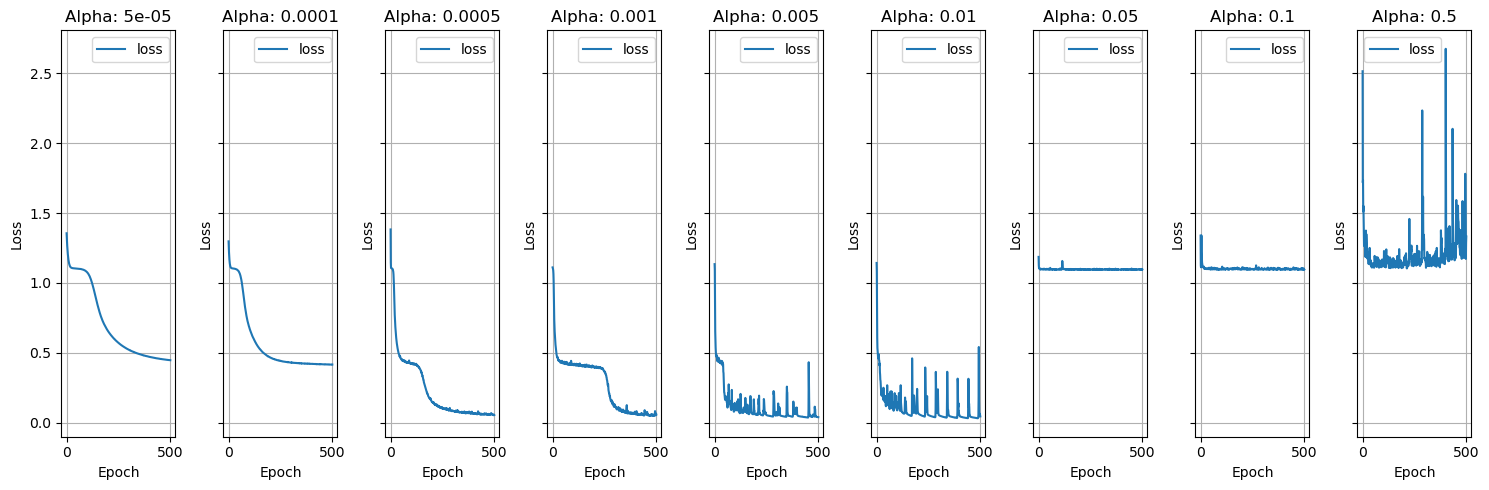

In [17]:
plot_training_histories(histories, alphas)

In the plots above, we can see that an Alpha value of 0.0005 converges to the lowest loss without being too unstable. The other alpha values either diverge, converge to a higher cost, or are generally unstable. 

### Determine the Final Model's Accuracy ###
After finding an optimal model architecture, determining an optimal lambda, and an optimal alpha value, we can test how well the model generalizes on the testing data.

In [23]:
def test_best_found_model(best_model, X, y):
  """
  Test the best-found model on the testing data to determine its accuracy.

  Args:
  best_model: The model identified as having the best performance in the graphs above
  X: Testing dataset features
  y: Classification labels for the dataset

  Returns:
  test_accuracy: The accuracy of the model on the testing data.
  """
  _, test_accuracy = best_model.evaluate(X, y, verbose=0)
  return test_accuracy


In [24]:
test_accuracy = test_best_found_model(alpha_models[2], X_test, y_test)
train_accuracy = test_best_found_model(alpha_models[2], X_train, y_train)
cv_accuracy = test_best_found_model(alpha_models[2], X_cv, y_cv)

print(f"The final model's accuracy on the testing data is: {test_accuracy * 100}%")
print(f"The final model's accuracy on the training data is: {train_accuracy * 100}%")
print(f"The final model's accuracy on the cross-validation data is: {cv_accuracy * 100}%")


The final model's accuracy on the testing data is: 97.08333611488342%
The final model's accuracy on the training data is: 99.58333373069763%
The final model's accuracy on the cross-validation data is: 98.7500011920929%


In the above code, we can see that the model has little variation between the training and testing data, showing it generalized extremely well. Furthermore, the similar accuracy on cv, test, and train show the model has low variance, and the high percentages show the model has low bias.